# Challenge: Make a Neural Network
__Create a multi-layer perceptron neural network model to predict on a labeled dataset of your choosing__. Compare this model to either a boosted tree or a random forest model and describe the relative tradeoffs between complexity and accuracy. Be sure to vary the hyperparameters of your MLP!

In [4]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import os
import matplotlib.pyplot as plt
%matplotlib inline
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')

## Import the Dataset

In [41]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

# use the credentials to start a connection
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

# Use the connection to extract SQL data
weather_df = pd.read_sql_query('SELECT * FROM weatherinszeged', con=engine)

#Close the connection after query is complete
engine.dispose()

In [7]:
weather_df.columns

Index(['date', 'summary', 'preciptype', 'temperature', 'apparenttemperature',
       'humidity', 'windspeed', 'windbearing', 'visibility', 'loudcover',
       'pressure', 'dailysummary'],
      dtype='object')

In [6]:
weather_df.head()

,date,summary,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure,dailysummary
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


## Data Cleaning

In [42]:
#Split date feature into usable features: hour, day, month, and year
day = []
month = []
year = []
hour = []
for date in weather_df['date']:
    year.append(int(str(date).split('-')[0]))
    month.append(int(str(date).split('-')[1]))
    day.append(int(str(date).split('-')[2].split(' ')[0]))
    hour.append(int(str(date).split(' ')[1].split(':')[0]))
    
weather_df['year'] = year
weather_df['month'] = month
weather_df['day'] = day
weather_df['hour'] = hour

In [43]:
#Drop columns that are not useful for clustering
weather_df = weather_df.drop(['date', 'summary', 'loudcover', 'dailysummary'], axis = 1)

In [10]:
#Check updated dataframe
weather_df.head()

,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,pressure,year,month,day,hour
0,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,1015.13,2006,3,31,22
1,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,1015.63,2006,3,31,23
2,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,1015.94,2006,4,1,0
3,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,1016.41,2006,4,1,1
4,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,1016.51,2006,4,1,2


In [44]:
weather_orig = weather_df.copy()

In [58]:
weather_df = weather_orig.copy()

## Visualize Target Variable

In [15]:
np.unique(weather_df['preciptype'])

array(['null', 'rain', 'snow'], dtype=object)

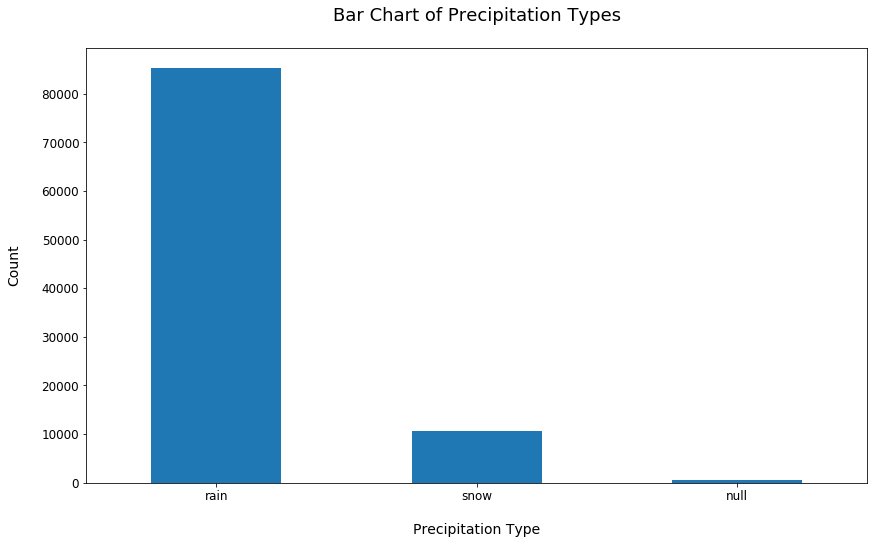

In [46]:
ax = weather_df['preciptype'].value_counts().plot(kind='bar', figsize=(14,8), fontsize = 12)
ax.set_title("Bar Chart of Precipitation Types\n", fontsize=18)
ax.set_xlabel("\nPrecipitation Type", fontsize=14)
ax.set_xticklabels(['rain', 'snow', 'null'], rotation=0)
ax.set_ylabel("Count\n", fontsize=14)
plt.show()

## Address Class Imbalance via Undersampling of Majority Label

In [59]:
weather_df = weather_df[weather_df['preciptype']!='null']
weather_df = weather_df.reset_index(drop=True)

In [60]:
X = weather_df[weather_df.columns.drop('preciptype')]
y = weather_df['preciptype']

In [61]:
unique_y = list(np.unique(y))
y = np.array([unique_y.index(i) for i in list(y)])
y

array([0, 0, 0, ..., 0, 0, 0])

In [62]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)

In [68]:
headers = X.columns
X_new = pd.DataFrame(columns = headers)

for i in range(len(headers)):
    X_new[headers[i]] = [row[i] for row in X_res]
    
y_new = pd.DataFrame([item for item in y_res], columns = ['Class'])

print(len(y_new[y_new['Class']==1]))
print(len(y_new[y_new['Class']==0]))

10712
10712


In [70]:
X = X_new.copy()
y = np.array(y_new['Class'])

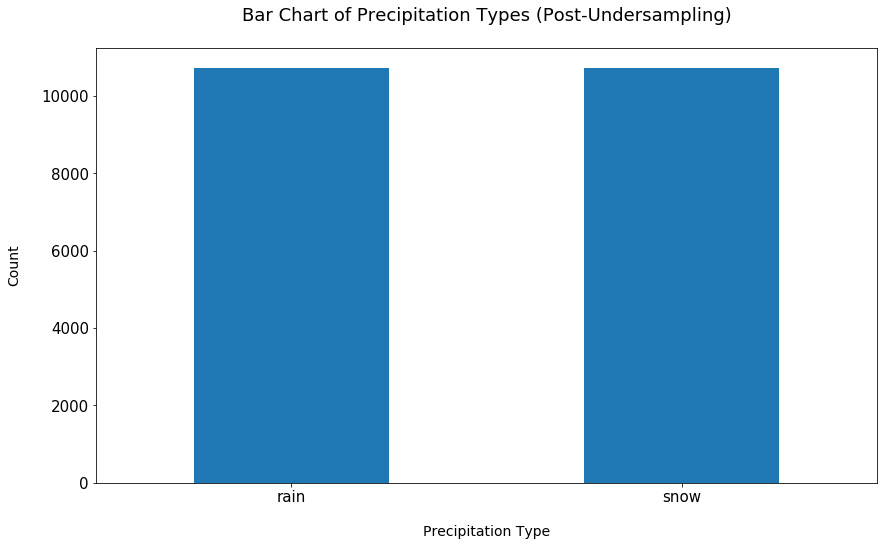

In [72]:
ax = pd.Series(y).value_counts().plot(kind='bar', figsize=(14,8), fontsize = 15)
ax.set_title("Bar Chart of Precipitation Types (Post-Undersampling)\n", fontsize=18)
ax.set_xlabel("\nPrecipitation Type", fontsize=14)
ax.set_xticklabels(unique_y, rotation=0)
ax.set_ylabel("Count\n", fontsize=14)
plt.show()

## Feature Selection

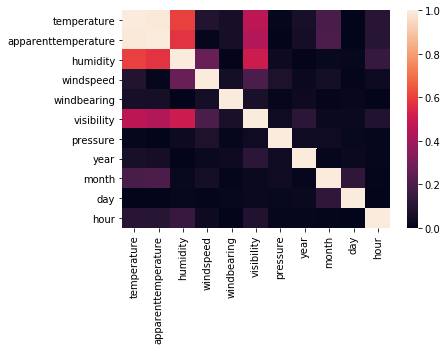

In [73]:
#Find the correlation between the existing features to see if we need to drop any
plt.figure()
sns.heatmap(abs(X.corr()))
plt.show()

In [74]:
#Drop apparenttemperature
X = X.drop('apparenttemperature', axis=1)

#preciptype is the target variable, everything else is a feature
headers = list(X.columns)

In [75]:
print(X.shape)
print(y.shape)

(21424, 10)
(21424,)


## Train-Test Split

In [77]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 450)

## Build a Default MLP Model

In [81]:
from sklearn.neural_network import MLPClassifier
# MLP
mlp = MLPClassifier(hidden_layer_sizes=(),random_state=42)
mlp.fit(X_train,y_train)
mlp.score(X_train, y_train)

0.7415251764980454

In [83]:
from sklearn.model_selection import cross_val_score
# 5-fold CV
scores = cross_val_score(mlp, X_train, y_train, cv=5)
print('Scores: ', scores)

print('\nAccuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Scores:  [0.61563138 0.61406068 0.59393232 0.61015465 0.61219726]

Accuracy: 0.61 (+/- 0.02)


## Build an Optimized MLP Model

In [85]:
# MLP Hyperparameter tuning
mlp_opt = MLPClassifier(max_iter=200,random_state=42)

In [86]:
param_options = {
    'hidden_layer_sizes': [(1000,),(500,),(100,)],
    'activation': ['relu','logistic'],
    'solver': ['sgd', 'lbfgs'],
    'alpha': [0.001, 0.000001],
    'learning_rate': ['constant','adaptive'],
}

In [87]:
from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(mlp_opt, param_options, n_jobs=-1, cv=3)
clf.fit(X_train, y_train)

# Best parameters
print('Best parameters found:\n', clf.best_params_)

Best parameters found:
 {'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'lbfgs'}


In [91]:
mlp2 = MLPClassifier(**clf.best_params_)
mlp2.fit(X_train,y_train)
mlp2.score(X_train, y_train)

0.98337125853317

In [90]:
# 5-fold CV
scores = cross_val_score(mlp2, X_train, y_train, cv=5)
print('Scores: ', scores)

print('\nAccuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Scores:  [0.91980169 0.98453909 0.98220537 0.98570178 0.96381675]

Accuracy: 0.97 (+/- 0.05)


## Boosted Tree Model

In [98]:
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix

# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
gb = ensemble.GradientBoostingClassifier(**params)
gb.fit(X_train, y_train)

predict_train = gb.predict(X_train)
predict_test = gb.predict(X_test)


# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.0
Percent Type II errors: 0.0

Test set accuracy:
Percent Type I errors: 0.0
Percent Type II errors: 0.0


In [99]:
gb.score(X_test, y_test)

#Create Confusion Matrix (outlines Type 1 and 2 Errors)
y_pred = gb.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[2169,    0],
       [   0, 2116]], dtype=int64)

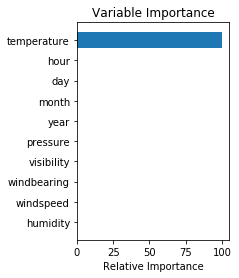

In [100]:
feature_importance = gb.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [101]:
# 5-fold CV
scores = cross_val_score(gb, X_train, y_train, cv=5)
print('Scores: ', scores)

print('\nAccuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Scores:  [1. 1. 1. 1. 1.]

Accuracy: 1.00 (+/- 0.00)


## Conclusions

The optimized MLP model gives very high accuracy, 0.97, but with a greater than ideal level of overfitting (variance of 0.05). Interestingly, the boosted gradient model for this dataset produces perfect accuracy. Upon deeper analysis, this result makes sense, as it shows that temperature has the highest relative feature importance, at 100%. Therefore, because this dataset has perfect correlation between temperature and precipitation type, the gradient boost classifier can achieve perfect prediction results.